In [86]:
%autosave 60

import os
import sys
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import Concatenate
#from google.colab import drive
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import cv2

Autosaving every 60 seconds


In [87]:
#drive.mount('/content/drive/')
#dataset_folder = 'drive/MyDrive/datasets/diver'
dataset_folder = 'C:/Users/lesni/Desktop/segmentation dataset/train_val/train_val'


images_folder = "/images"
masks_folder = "/masks"
masks_format = "bmp"

def load_data(max_num):
  imgs = []
  msks = []

  count = 0

  for fname in os.listdir(dataset_folder + images_folder):
    if count >= max_num:
      break
    count += 1

    img = cv2.imread(os.path.join(dataset_folder + images_folder, fname))
    msk = cv2.imread(os.path.join(dataset_folder + masks_folder, fname[:-3] + masks_format))

    if img is not None and msk is not None:
      imgs.append(img)
      msks.append(msk)

  return [imgs, msks]

In [88]:
images, masks = load_data(100)

for i in range(len(images)):
  images[i] = cv2.resize(images[i], (128,128))
  masks[i] = cv2.resize(masks[i], (128,128))

images = np.array(images)
masks = np.array(masks)

In [89]:
images = images/255.
masks = masks/255.

In [90]:
def delete_noise(masks):
    for i in range(masks.shape[0]):
        for j in range(masks.shape[1]):
            for k in range(masks.shape[2]):
                for m in range(masks.shape[3]):
                    if (masks[i,j,k,m] != 1.):
                        masks[i,j,k,m] = 0.

In [91]:
delete_noise(masks)

In [92]:
NUM_CLASSES = 8

c1 = np.unique(masks[:,:,:,0])
c2 = np.unique(masks[:,:,:,1])
c3 = np.unique(masks[:,:,:,2])

print(c1,c2,c3)

[0. 1.] [0. 1.] [0. 1.]


In [93]:
colors = [
    [0,0,0],
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1],
]

def cat_masks(masks):
    masks_for_cat = np.empty([masks.shape[0], masks.shape[1], masks.shape[2]], 'float')

    for i in range(masks.shape[0]):
        for j in range(masks.shape[1]):
            for k in range(masks.shape[2]):
                masks_for_cat[i,j,k] = colors.index(masks[i,j,k].tolist())
            
    masks_cat = to_categorical(masks_for_cat, NUM_CLASSES)
    
    return masks_cat

def reverse_cat(masks_cat):
    
    masks = np.empty(shape=[masks_cat.shape[0],masks_cat.shape[1],masks_cat.shape[2],3])
    
    for i in range(masks_cat.shape[0]):
        for j in range(masks_cat.shape[1]):
            for k in range(masks_cat.shape[2]):
                ind = np.argmax(masks_cat[i,j,k])
                masks[i,j,k] = np.array(colors[ind])
                        
    return masks

In [94]:
masks_cat = cat_masks(masks)

print(masks_cat.shape)

(100, 128, 128, 8)


In [95]:
def down_conv(prev_layer, num_layers,  kernel_size=(3,3), padding="same", strides=1, activation="relu"):
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(prev_layer)
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conv)
  pool = MaxPool2D((2,2), (2,2))(conv)

  return [conv, pool]

def up_conv(prev_layer, skip_layer, num_layers,  kernel_size=(3,3), padding="same", strides=1, activation="relu"):
  upsamp = UpSampling2D((2,2))(prev_layer)
  conc = Concatenate()([upsamp, skip_layer])
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conc)
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conv)

  return conv

def bootle_neck(prev_layer, num_layers,  kernel_size=(3,3), padding="same", strides=1, activation="relu"):
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(prev_layer)
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conv)

  return conv

def reduce_layers(layer, num_classes):
  return Conv2D(num_classes, (1,1), padding="same", activation="softmax")(layer)

In [96]:

input = keras.layers.Input((128,128,3))
conv1, pool1 = down_conv(input, 16)
conv2, pool2 = down_conv(pool1, 32)
conv3, pool3 = down_conv(pool2, 64)
conv4, pool4 = down_conv(pool3, 128)

bneck = bootle_neck(pool4, 256)

up1 = up_conv(bneck, conv4, 128)
up2 = up_conv(up1, conv3, 64)
up3 = up_conv(up2, conv2, 32)
up4 = up_conv(up3, conv1, 16)

output = reduce_layers(up4, NUM_CLASSES)

model = keras.models.Model(input, output)

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 128, 128, 16)         448       ['input_4[0][0]']             
                                                                                                  
 conv2d_58 (Conv2D)          (None, 128, 128, 16)         2320      ['conv2d_57[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 16)           0         ['conv2d_58[0][0]']           
 ng2D)                                                                                      

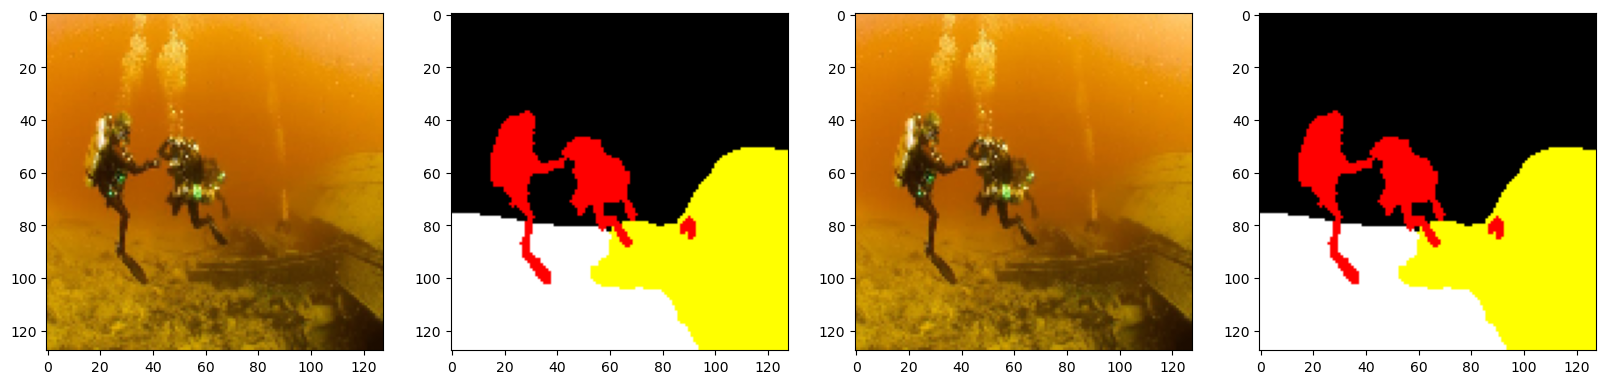

In [97]:
plt.figure(figsize=(20,10))

plt.subplot(141)
plt.imshow(images[0])
plt.subplot(142)
plt.imshow(masks[0])

plt.subplot(143)
plt.imshow(images[0])
plt.subplot(144)
plt.imshow(masks[0])

plt.show()


In [98]:
model.fit(images, masks_cat, epochs=200, validation_split=0.2)

Epoch 1/200
3/3 [==============================] - 12s 3s/step - loss: 2.0677 - accuracy: 0.1458 - val_loss: 2.0157 - val_accuracy: 0.2011
Epoch 2/200
3/3 [==============================] - 8s 2s/step - loss: 1.9696 - accuracy: 0.2049 - val_loss: 1.8762 - val_accuracy: 0.2122
Epoch 3/200
3/3 [==============================] - 8s 2s/step - loss: 1.8551 - accuracy: 0.2495 - val_loss: 1.7076 - val_accuracy: 0.2881
Epoch 4/200
3/3 [==============================] - 7s 2s/step - loss: 1.7802 - accuracy: 0.2616 - val_loss: 1.7735 - val_accuracy: 0.2516
Epoch 5/200
3/3 [==============================] - 7s 2s/step - loss: 1.7589 - accuracy: 0.2945 - val_loss: 1.6137 - val_accuracy: 0.3182
Epoch 6/200
3/3 [==============================] - 8s 2s/step - loss: 1.6401 - accuracy: 0.3991 - val_loss: 1.5019 - val_accuracy: 0.4887
Epoch 7/200
3/3 [==============================] - 8s 2s/step - loss: 1.6016 - accuracy: 0.4526 - val_loss: 1.4723 - val_accuracy: 0.4918
Epoch 8/200
3/3 [================

Epoch 60/200
3/3 [==============================] - 7s 2s/step - loss: 1.0508 - accuracy: 0.6524 - val_loss: 1.2128 - val_accuracy: 0.6177
Epoch 61/200
3/3 [==============================] - 6s 2s/step - loss: 1.0475 - accuracy: 0.6502 - val_loss: 1.4844 - val_accuracy: 0.5162
Epoch 62/200
3/3 [==============================] - 6s 2s/step - loss: 1.0364 - accuracy: 0.6497 - val_loss: 1.2192 - val_accuracy: 0.6082
Epoch 63/200
3/3 [==============================] - 7s 2s/step - loss: 0.9951 - accuracy: 0.6705 - val_loss: 1.2209 - val_accuracy: 0.6074
Epoch 64/200
3/3 [==============================] - 6s 2s/step - loss: 0.9829 - accuracy: 0.6680 - val_loss: 1.2770 - val_accuracy: 0.5928
Epoch 65/200
3/3 [==============================] - 6s 2s/step - loss: 0.9331 - accuracy: 0.6943 - val_loss: 1.2053 - val_accuracy: 0.5997
Epoch 66/200
3/3 [==============================] - 7s 2s/step - loss: 0.9058 - accuracy: 0.7057 - val_loss: 1.2082 - val_accuracy: 0.6072
Epoch 67/200
3/3 [=========

Epoch 119/200
3/3 [==============================] - 6s 2s/step - loss: 0.3908 - accuracy: 0.8607 - val_loss: 1.9264 - val_accuracy: 0.6109
Epoch 120/200
3/3 [==============================] - 6s 2s/step - loss: 0.3689 - accuracy: 0.8613 - val_loss: 2.0311 - val_accuracy: 0.5919
Epoch 121/200
3/3 [==============================] - 7s 2s/step - loss: 0.3893 - accuracy: 0.8662 - val_loss: 2.0245 - val_accuracy: 0.5623
Epoch 122/200
3/3 [==============================] - 7s 2s/step - loss: 0.3992 - accuracy: 0.8610 - val_loss: 2.2381 - val_accuracy: 0.6328
Epoch 123/200
3/3 [==============================] - 7s 2s/step - loss: 0.3753 - accuracy: 0.8688 - val_loss: 1.7604 - val_accuracy: 0.5865
Epoch 124/200
3/3 [==============================] - 7s 2s/step - loss: 0.3378 - accuracy: 0.8918 - val_loss: 2.2536 - val_accuracy: 0.6363
Epoch 125/200
3/3 [==============================] - 7s 2s/step - loss: 0.3270 - accuracy: 0.8820 - val_loss: 1.9532 - val_accuracy: 0.5808
Epoch 126/200
3/3 [=

3/3 [==============================] - 6s 2s/step - loss: 0.0896 - accuracy: 0.9670 - val_loss: 3.4734 - val_accuracy: 0.6107
Epoch 178/200
3/3 [==============================] - 6s 2s/step - loss: 0.0917 - accuracy: 0.9666 - val_loss: 3.3075 - val_accuracy: 0.5902
Epoch 179/200
3/3 [==============================] - 6s 2s/step - loss: 0.0880 - accuracy: 0.9674 - val_loss: 3.3417 - val_accuracy: 0.6088
Epoch 180/200
3/3 [==============================] - 6s 2s/step - loss: 0.0881 - accuracy: 0.9682 - val_loss: 3.3311 - val_accuracy: 0.6042
Epoch 181/200
3/3 [==============================] - 6s 2s/step - loss: 0.0868 - accuracy: 0.9674 - val_loss: 3.4802 - val_accuracy: 0.6042
Epoch 182/200
3/3 [==============================] - 7s 2s/step - loss: 0.0850 - accuracy: 0.9685 - val_loss: 3.4826 - val_accuracy: 0.6110
Epoch 183/200
3/3 [==============================] - 7s 2s/step - loss: 0.0838 - accuracy: 0.9686 - val_loss: 3.4387 - val_accuracy: 0.5872
Epoch 184/200
3/3 [===============

1/1 [==============================] - 0s 65ms/step


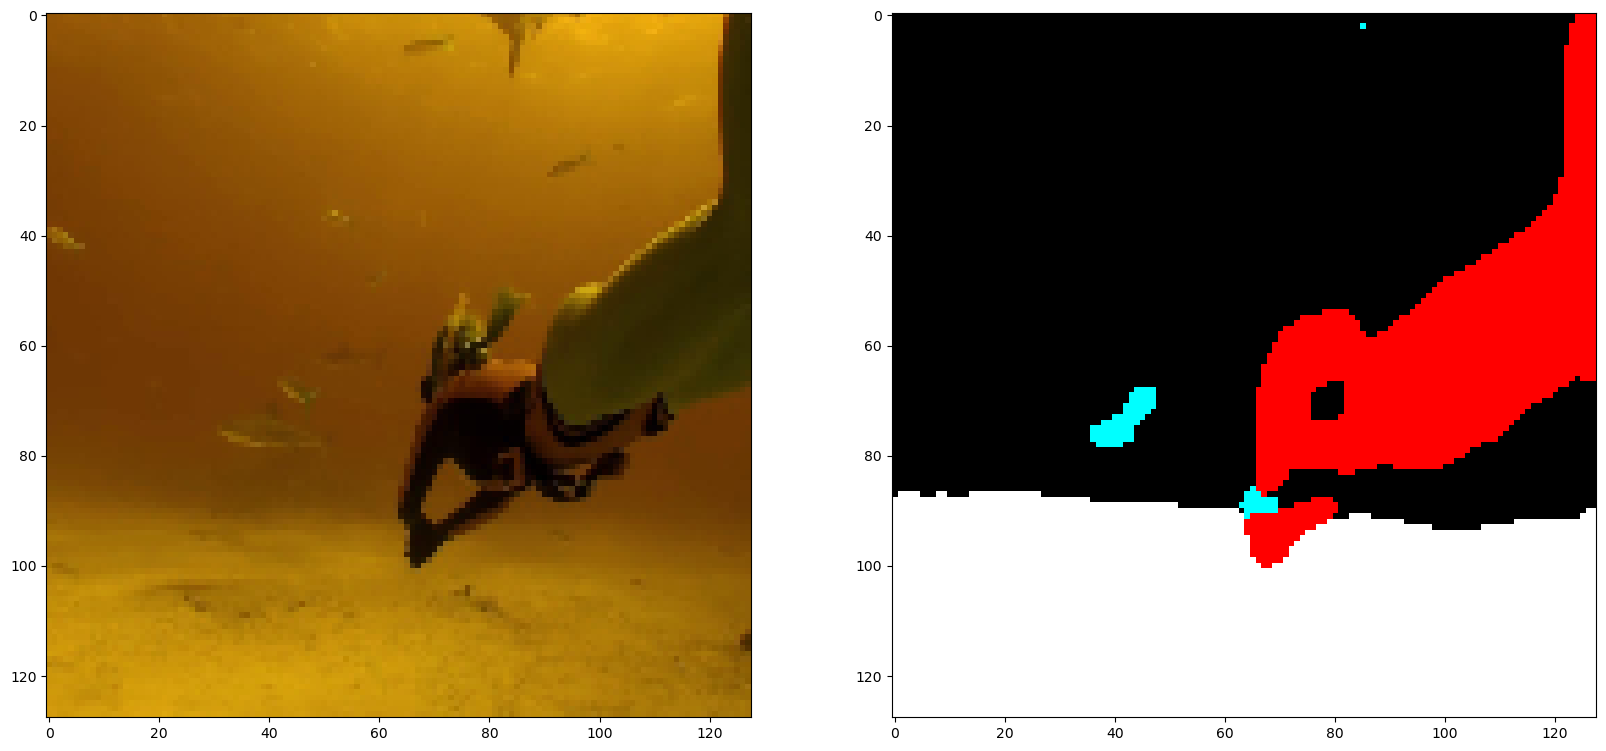

In [107]:
num = 70

pred = model.predict(np.array([images[num]]))

pred_mask = reverse_cat(pred)

plt.figure(figsize=[20,10])
plt.subplot(121)
plt.imshow(images[num])
plt.subplot(122)
plt.imshow(pred_mask[0])
plt.show()